In [2]:
import numpy as np
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm
import os 
import shutil
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

The next cell creates the training and testing working directories and copies images from the original dataset. 200 images per class are copied for training and 50 per class for testing. (400 total for training and 100 total for testing, thus achieving a balanced dataset with an 80/20 split)

In [3]:

# Define paths
data_dir = 'data/'
train_dir = 'train/'
test_dir = 'test/'

# Clear train and test directories
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image filenames in each class folder
malignant_images = os.listdir(os.path.join(data_dir, 'malignant'))
normal_images = os.listdir(os.path.join(data_dir, 'normal'))

# Shuffle the filenames
random.shuffle(malignant_images)
random.shuffle(normal_images)

# Define the number of images for training and testing
train_count = 200
test_count = 50

# Split images into training and testing sets
malignant_train_images = malignant_images[:train_count]
malignant_test_images = malignant_images[train_count:train_count+test_count]

normal_train_images = normal_images[:train_count]
normal_test_images = normal_images[train_count:train_count+test_count]

# Copy images to train and test folders
for img in malignant_train_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_train = os.path.join(train_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in malignant_test_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_test = os.path.join(test_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

for img in normal_train_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_train = os.path.join(train_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in normal_test_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_test = os.path.join(test_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

print("Data copied successfully.")

Data copied successfully.


To verify that each directory has the expected number of image data.

In [5]:

# Define directories
train_dir = 'train/'
test_dir = 'test/'

# Count number of files in train directory
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
train_normal_count = len(os.listdir(os.path.join(train_dir, 'normal')))

# Count number of files in test directory
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'malignant')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'normal')))

# Print counts
print("Train directory:")
print(f"Malignant: {train_malignant_count} images")
print(f"Normal: {train_normal_count} images")

print("\nTest directory:")
print(f"Malignant: {test_malignant_count} images")
print(f"Normal: {test_normal_count} images")


Train directory:
Malignant: 200 images
Normal: 200 images

Test directory:
Malignant: 50 images
Normal: 50 images


The train and test generators are defined. The batch size is set to the max number of images in each set to ensure each model is trained using the same dataset (makes for a fair comparasion.) Each image is modified to be 128x128 pixels to ensure uniformity. The image is also labeled as 0 or 1 depedning on which class it belongs to. Shuffle is set to false to ensure that the the same test set is used when calculating metrics.

In [6]:
# Define image dimensions and other parameters
img_height = 128
img_width = 128
epochs = 10

# Create ImageDataGenerators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=400,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=100,
    class_mode='binary',
    shuffle=False)


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Validating that the test set has all data present.

In [7]:
x_test, y_test = next(test_generator)

print(x_test.shape, y_test.shape)
num_samples = x_test.shape[0]
print("Number of samples in x_test:", num_samples)


(100, 128, 128, 3) (100,)
Number of samples in x_test: 100


In [8]:
import tensorflow as tf

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


# Create an instance of the model
model = create_model(input_shape=(img_height, img_width, 3))

model.summary()

# Fit the model
history = model.fit(train_generator, epochs=10, batch_size=32, validation_data=train_generator, verbose=2)  

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 - 29s - 29s/step - accuracy: 0.4100 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 1.7130
Epoch 2/10
1/1 - 16s - 16s/step - accuracy: 0.5000 - loss: 1.7130 - val_accuracy: 0.5000 - val_loss: 0.6406
Epoch 3/10
1/1 - 16s - 16s/step - accuracy: 0.5000 - loss: 0.6406 - val_accuracy: 0.5225 - val_loss: 0.6475
Epoch 4/10
1/1 - 17s - 17s/step - accuracy: 0.5225 - loss: 0.6475 - val_accuracy: 0.7475 - val_loss: 0.6565
Epoch 5/10
1/1 - 17s - 17s/step - accuracy: 0.7475 - loss: 0.6565 - val_accuracy: 0.5225 - val_loss: 0.6215
Epoch 6/10
1/1 - 8s - 8s/step - accuracy: 0.5225 - loss: 0.6215 - val_accuracy: 0.4975 - val_loss: 0.5685
Epoch 7/10
1/1 - 23s - 23s/step - accuracy: 0.4975 - loss: 0.5685 - val_accuracy: 0.7375 - val_loss: 0.6333
Epoch 8/10
1/1 - 13s - 13s/step - accuracy: 0.7375 - loss: 0.6333 - val_accuracy: 0.7325 - val_loss: 0.5383
Epoch 9/10
1/1 - 18s - 18s/step - accuracy: 0.7325 - loss: 0.5383 - val_accuracy: 0.7675 - val_loss: 0.5326
Epoch 10/10
1/1 - 17s - 17s/step - accura

CustomKerasClassifer() is instantiated to facilitate grid search to find the optimum hyperparameters.

In [39]:

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', epochs=10, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


Defining function to create CNN model to be called when performing grid search 

In [40]:
# Define CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# Wrap Keras model in a scikit-learn compatible classifier
model = CustomKerasClassifier(build_fn=create_model, verbose=0)


Setting up a hyperparamter grid with potential values and conducting a grid search. Apporx run time: ~66 m

Summary of all models fitted during grid search. Best model highlighted.

In [93]:
results = grid_search.cv_results_

best_rank = min(results['rank_test_score'])
best_index = np.where(results['rank_test_score'] == best_rank)[0][0]

results_dict = {
    'Mean Test Score': results['mean_test_score'],
    'Std Test Score': results['std_test_score'],
    'Mean Train Score': results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank': results['rank_test_score'],
    'Hyperparameters': results['params'],
    'Mean Fit Time': results['mean_fit_time'],
    'Std Fit Time': results['std_fit_time'],
    'Mean Score Time': results['mean_score_time'],
    'Std Score Time': results['std_score_time']
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Highlight the best model
best_model_index = np.where(results['rank_test_score'] == best_rank)[0][0]
results_df.loc[best_model_index, 'Best Model'] = 'Yes'
results_df.fillna('No', inplace=True)

# Display the DataFrame
results_df



Mean Test Score  Std Test Score  Mean Train Score  Std Train Score  Rank  \
0            0.8575        0.064517          0.947500         0.040955     6   
1            0.6925        0.042279          0.718750         0.029580    18   
2            0.8875        0.035355          0.976250         0.020406     2   
3            0.7475        0.067268          0.781250         0.046561    11   
4            0.8875        0.043301          0.995000         0.005796     2   
5            0.7775        0.044300          0.827500         0.029541     9   
6            0.8500        0.015811          0.908750         0.051516     7   
7            0.7025        0.016583          0.721875         0.017343    16   
8            0.8850        0.024238          0.949375         0.034765     4   
9            0.7075        0.038406          0.703750         0.021955    15   
10           0.9025        0.039051          0.987500         0.010643     1   
11           0.7225        0.027839          0.760000         0.009961    13   
12           0.7675        0.025739          0.831250         0.032894    10   
13           0.7275        0.034821          0.728750         0.006060    12   
14           0.8300        0.052797          0.866250         0.042177     8   
15           0.7125        0.034460          0.718750         0.010270    14   
16           0.8675        0.053968          0.896250         0.045902     5   
17           0.7025        0.030000          0.727500         0.021777    16   

                                      Hyperparameters  Mean Fit Time  \
0   {'batch_size': 32, 'epochs': 10, 'optimizer': ...      47.545958   
1   {'batch_size': 32, 'epochs': 10, 'optimizer': ...      37.403491   
2   {'batch_size': 32, 'epochs': 15, 'optimizer': ...      61.937014   
3   {'batch_size': 32, 'epochs': 15, 'optimizer': ...      39.770807   
4   {'batch_size': 32, 'epochs': 20, 'optimizer': ...      55.474010   
5   {'batch_size': 32, 'epochs': 20, 'optimizer': ...      52.367902   
6   {'batch_size': 64, 'epochs': 10, 'optimizer': ...      26.650792   
7   {'batch_size': 64, 'epochs': 10, 'optimizer': ...      23.845262   
8   {'batch_size': 64, 'epochs': 15, 'optimizer': ...      38.279504   
9   {'batch_size': 64, 'epochs': 15, 'optimizer': ...      35.767320   
10  {'batch_size': 64, 'epochs': 20, 'optimizer': ...      49.717132   
11  {'batch_size': 64, 'epochs': 20, 'optimizer': ...      47.185778   
12  {'batch_size': 128, 'epochs': 10, 'optimizer':...      27.529428   
13  {'batch_size': 128, 'epochs': 10, 'optimizer':...      29.025693   
14  {'batch_size': 128, 'epochs': 15, 'optimizer':...      41.013222   
15  {'batch_size': 128, 'epochs': 15, 'optimizer':...      38.506080   
16  {'batch_size': 128, 'epochs': 20, 'optimizer':...      52.033190   
17  {'batch_size': 128, 'epochs': 20, 'optimizer':...      48.741412   

    Std Fit Time  Mean Score Time  Std Score Time Best Model  
0      12.202257         1.013719        0.091441        nan  
1       2.433640         1.115575        0.076438        nan  
2       8.271718         1.094013        0.281086        nan  
3       2.875267         0.651964        0.111910        nan  
4       1.464126         0.707522        0.140704        nan  
5       1.822867         0.746129        0.187176        nan  
6       1.115385         0.680977        0.115606        nan  
7       0.397001         0.620336        0.043857        nan  
8       0.302006         0.588250        0.020213        nan  
9       0.572653         0.609424        0.021468        nan  
10      0.431378         0.596987        0.025450        Yes  
11      0.865974         0.898461        0.329042        nan  
12      1.196464         0.660409        0.048006        nan  
13      1.439181         0.818013        0.039794        nan  
14      0.840688         0.689323        0.065771        nan  
15      1.812672         0.672764        0.048853        nan  
16      0.650489         0.612265        0.

Confirming best hyperparamters 

In [94]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'batch_size': 64, 'epochs': 20, 'optimizer': 'adam'}


Fitting a new model with the best hyperparameters

In [107]:
import tensorflow as tf

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


# Create an instance of the model
model = create_model(input_shape=(img_height, img_width, 3))

model.summary()

# Fit the model
history = model.fit(train_generator, epochs=20, batch_size=64, validation_data=train_generator, verbose=2)  

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_429 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_429               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_430 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_430               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_431 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_431               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_143 (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 - 14s - 14s/step - accuracy: 0.2950 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.8042
Epoch 2/20
1/1 - 28s - 28s/step - accuracy: 0.5000 - loss: 0.8042 - val_accuracy: 0.5000 - val_loss: 0.6317
Epoch 3/20
1/1 - 24s - 24s/step - accuracy: 0.5000 - loss: 0.6317 - val_accuracy: 0.5000 - val_loss: 0.6275
Epoch 4/20
1/1 - 12s - 12s/step - accuracy: 0.5000 - loss: 0.6275 - val_accuracy: 0.5000 - val_loss: 0.5945
Epoch 5/20
1/1 - 25s - 25s/step - accuracy: 0.5000 - loss: 0.5945 - val_accuracy: 0.5000 - val_loss: 0.6069
Epoch 6/20
1/1 - 12s - 12s/step - accuracy: 0.5000 - loss: 0.6069 - val_accuracy: 0.7375 - val_loss: 0.5486
Epoch 7/20
1/1 - 24s - 24s/step - accuracy: 0.7375 - loss: 0.5486 - val_accuracy: 0.5275 - val_loss: 0.5329
Epoch 8/20
1/1 - 22s - 22s/step - accuracy: 0.5275 - loss: 0.5329 - val_accuracy: 0.7600 - val_loss: 0.5212
Epoch 9/20
1/1 - 27s - 27s/step - accuracy: 0.7600 - loss: 0.5212 - val_accuracy: 0.7500 - val_loss: 0.5175
Epoch 10/20
1/1 - 7s - 7s/st

Printing Test accuracy and Test loss


In [108]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4894055426120758
Test accuracy: 0.7799999713897705


Comparing validation loss to normal loss 

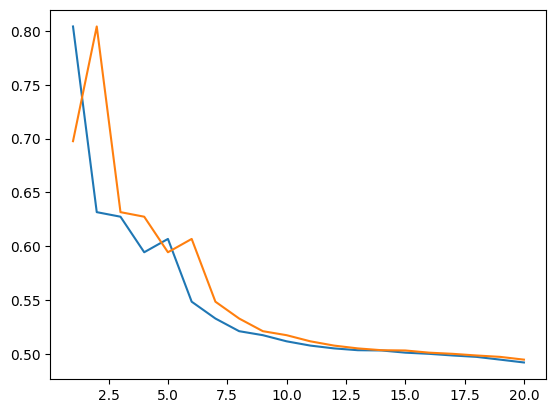

In [109]:
vy = history.history['val_loss']
ty = history.history['loss']
x = list(range(1, len(vy) + 1))  # Adjust x to represent the range of epochs


plt.plot(x, vy)
plt.plot(x, ty)
plt.show()


Printing metrics for classifcation for training and testing datasets. (Accuracies, Sensitivity, Specificity, and classifcation report)

In [110]:

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Accuracy:", train_accuracy)

# Make predictions on the train set
train_predictions = model.predict(train_generator)
y_train_pred = np.where(train_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the train set
true_train_labels = train_generator.classes

# Print classification report for train data
print("Classification Report (Train Data):")
print(classification_report(true_train_labels, y_train_pred))

# Print accuracy for train data
accuracy_train = accuracy_score(true_train_labels, y_train_pred)
print("Accuracy (Train Data):", accuracy_train)

# Calculate confusion matrix for train data
conf_matrix_train = confusion_matrix(true_train_labels, y_train_pred)

# Calculate true positives, false negatives, true negatives, and false positives for train data
tp_train = conf_matrix_train[1, 1]
fn_train = conf_matrix_train[1, 0]
tn_train = conf_matrix_train[0, 0]
fp_train = conf_matrix_train[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for train data
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

# Print sensitivity and specificity for train data
print("Sensitivity (Train Data):", sensitivity_train)
print("Specificity (Train Data):", specificity_train)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(test_generator)
y_test_pred = np.where(test_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the test set
true_test_labels = test_generator.classes

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(true_test_labels, y_test_pred))

# Print accuracy for test data
accuracy_test = accuracy_score(true_test_labels, y_test_pred)
print("Accuracy (Test Data):", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(true_test_labels, y_test_pred)

# Calculate true positives, false negatives, true negatives, and false positives for test data
tp_test = conf_matrix_test[1, 1]
fn_test = conf_matrix_test[1, 0]
tn_test = conf_matrix_test[0, 0]
fp_test = conf_matrix_test[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for test data
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print sensitivity and specificity for test data
print("Sensitivity (Test Data):", sensitivity_test)
print("Specificity (Test Data):", specificity_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7975 - loss: 0.4921
Train Accuracy: 0.7975000143051147
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       200
           1       0.74      0.91      0.82       200

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400

Accuracy (Train Data): 0.7975
Sensitivity (Train Data): 0.905
Specificity (Train Data): 0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.7800 - loss: 0.4894

Test Accuracy: 0.7799999713897705
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.87      0.66      0.75        50
           1       0.73      0.90      0.80        50

    accuracy                           0.78       100
   

Plotting confusion matrix 

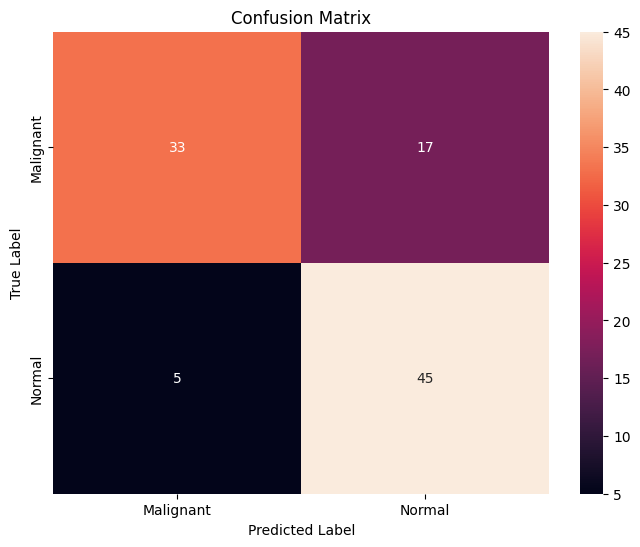

In [120]:
classes = ['Malignant', 'Normal']

# Compute confusion matrix
conf_matrix = cm(true_test_labels, y_test_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
